In [19]:
import logging
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sompy
from sompy.decorators import timeit
from sompy.sompy import SOMFactory
logging.getLogger().setLevel(logging.WARNING)
import itertools
import functools
import datetime as dt

In [20]:
from tfprop_sompy.tfprop_vis import render_posmap_to_axes, kmeans_clust, ViewTFP

In [21]:
from IPython.display import display

In [22]:
#logging.getLogger().setLevel(logging.WARNING)

In [23]:
#file location
fin = 'DummyData.csv'

#Map size needs to be a square and larger than the dataset
mapsize = (30, 30)
n_job = 1

#Reads CSV as data frame
mats_data_df = pd.read_csv(fin)

In [24]:
#Makes data frame of index values
mats_name_df = pd.DataFrame(mats_data_df.index)
km_cluster = 4

In [26]:
som_columns = [
# columns with values that are not numerical should be excluded
    "Set_1",
    "Set_2",
    "Set_3",
    "Set_4",
]

In [27]:
descr = mats_data_df[som_columns].values

In [28]:
# monkeypatch _batchtrain so we can display what's going on
def _batchtrain_monkeypatch(self, trainlen, radiusin, radiusfin, njob=1,
                shared_memory=False):
    from time import time
    radius = np.linspace(radiusin, radiusfin, trainlen)

    if shared_memory:
        data = self._data
        data_folder = tempfile.mkdtemp()
        data_name = os.path.join(data_folder, 'data')
        dump(data, data_name)
        data = load(data_name, mmap_mode='r')

    else:
        data = self._data

    bmu = None

    # X2 is part of euclidean distance (x-y)^2 = x^2 +y^2 - 2xy that we use
    # for each data row in bmu finding.
    # Since it is a fixed value we can skip it during bmu finding for each
    # data point, but later we need it calculate quantification error
    fixed_euclidean_x2 = np.einsum('ij,ij->i', data, data)

    logging.info(" radius_ini: %f , radius_final: %f, trainlen: %d\n" %
                 (radiusin, radiusfin, trainlen))

    for i in range(trainlen):
        t1 = time()
        neighborhood = self.neighborhood.calculate(
            self._distance_matrix, radius[i], self.codebook.nnodes)
        bmu = self.find_bmu(data, njb=njob)
        self.codebook.matrix = self.update_codebook_voronoi(data, bmu,
                                                            neighborhood)

        #lbugnon: ojo! aca el bmy[1] a veces da negativo, y despues de eso se rompe...hay algo raro ahi
        qerror = (i + 1, round(time() - t1, 3),
                  np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
        #lbugnon
        #ipdb.set_trace()
        #
        logging.info(
            " epoch: %d ---> elapsed time:  %f, quantization error: %f\n" %
            qerror)
        
        # this is the reason why we override the function
        update_sm_info(*qerror)
        
        if np.any(np.isnan(qerror)):
            logging.info("nan quantization error, exit train\n")

            #sys.exit("quantization error=nan, exit train")

    bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
    self._bmu = bmu
sompy.sompy.SOM._batchtrain = _batchtrain_monkeypatch

In [29]:
#Shows size of data
descr.shape
#som_columns

(560, 4)

In [30]:
sm = SOMFactory.build(descr, 
                      mapsize=mapsize, 
                      normalization='var', 
                      initialization='pca', 
                      component_names=som_columns
                     )

In [31]:
#With sample data set, should that Epoch: 1800 bc of no real correlation

%matplotlib notebook
# I'm pretty sure the sompy library's doing a lot of not-nice things to the global matplotlib state

#This is the creation of the Training and save box
b = widgets.Button(description="Train")
out = widgets.Output(layout={'border': '1px solid black'})
hm_output = widgets.Output()

# Saves the trained som data for use in SOM_Visualization
def save_som_data(sm: sompy.sompy.SOM, name: str):
    # This will overwrite the old hd5 file, so be aware
    with pd.HDFStore(name, mode="w") as store:
        store['sm_codebook_matrix'] = pd.DataFrame(sm.codebook.matrix, columns=som_columns)
        store['sm_data'] = mats_data_df.drop("Row", axis='columns')
        store['sm_codebook_mapsize'] = pd.Series(mapsize)
        # FIXME: This does a direct access of the pandas dataframe internals
        # in order to directly write to the file
        # For some reason writing an object("string") series to the store
        # renders it unreadable
        columns_group = store._handle.create_group(store._handle.root, 'sm_codebook_columns')
        stored_columns_array = store._handle.create_array(columns_group, "property_names", list(som_columns), "Material property names")
        matfamilies_group = store._handle.create_group(store._handle.root, 'sm_codebook_matfamilies')
        stored_matfamilies_array = store._handle.create_array(matfamilies_group, "material_families", list(mats_data_df["Row"]), "Material families")
    with out:
        print(f"Saved to {name}")

#This trains the data
def do_training(*args):
    out.clear_output()
    with out:
        sm.train(n_job=n_job, verbose='debug', train_rough_len=0,
                 train_finetune_len=0)

        topographic_error = sm.calculate_topographic_error()
        quantization_error = np.mean(sm._bmu[1])
        print("Topographic error = {:.5f}; Quantization error = {:.5f};"
              .format(topographic_error, quantization_error))
b.on_click(do_training)

# Produces text for the widget box
epoch_text_widget = widgets.Label(value="Epoch: 0")
topo_err_text_widget = widgets.Label(value="Topographic error: 0")
quantization_err_text_widget = widgets.Label(value="Quantization error: 0")
infobox = widgets.VBox([epoch_text_widget, topo_err_text_widget, quantization_err_text_widget])

# Gives file name and saves it
today = dt.date.today()
outname = widgets.Text(description="Output file", value=f"som_codemat_{len(som_columns)}props_{today.strftime('%y-%m-%d')}.h5")
savebtn = widgets.Button(description="Save")
savebox = widgets.VBox([outname, savebtn], layout={'border': '1px solid black'})

savebtn.on_click(lambda *args: save_som_data(sm, outname.value))

# Displayes the widgets below
graph_display = widgets.Output()
with graph_display:
    display(hm_output)
    
# Updates as data gets trained
def update_sm_info(epoch, topographic_err, quantization_err):
    epoch_text_widget.value = "Epoch: {}".format(epoch)
    topo_err_text_widget.value = "Topographic error: {}".format(topographic_err)
    quantization_err_text_widget.value = "Quantization error: {}".format(quantization_err)

widgets.VBox([graph_display, widgets.Box([widgets.VBox([savebox, b, infobox]), out])])

# When training with dummy data is done, epoch: 65
# No need to move past this part of the code, switch to SOM_Visualization for trained data

In [34]:
%matplotlib inline
from tfprop_sompy.tfprop_vis import show_posmap
logging.getLogger().setLevel(logging.WARNING)

def create_posmap(mysom: sompy.sompy.SOM, num_clusters: int=km_cluster):
    cl_labels = kmeans_clust(mysom, n_clusters=num_clusters)

    # plot positioning map with clustered groups
    show_posmap(mysom, mats_name_df, mats_name_df,
                km_cluster, cl_labels,
                show_data=False, labels=False)

backend module://ipykernel.pylab.backend_inline version unknown


Performing K-means clustering to SOM trained data...


C:\Users\Felic\Miniconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


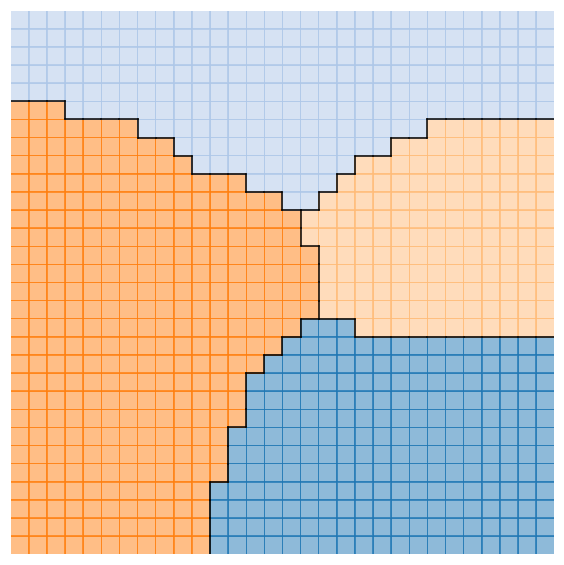

In [35]:
%matplotlib inline
create_posmap(sm)

In [ ]:
# Creates maps with different cluster numbers
o = widgets.Output()
with o:
    for i in range(2, 20):
        create_posmap(sm, num_clusters=i)
o

Output()

In [18]:
%matplotlib inline
from tfprop_sompy.tfprop_vis import ViewTFP
logging.getLogger().setLevel(logging.WARNING)
heatmap_size = (20, 20)
heatmap_col_sz = 4
gauss_alpha = None

viewTFP = ViewTFP(*heatmap_size, '', stdev_colorscale_coeff=1., text_size=14)

In [ ]:
my_out = widgets.Output()
cmap = plt.get_cmap('RdYlBu_r')  # set color map
cl_labels = kmeans_clust(sm, n_clusters=km_cluster)

# No scaling
viewTFP.knee_value = 0.0
with my_out:
    print("Linear scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap)
my_out

In [ ]:
my_out = widgets.Output()
cmap = plt.get_cmap('RdYlBu_r')  # set color map
cl_labels = kmeans_clust(sm, n_clusters=km_cluster)

# No scaling
viewTFP.knee_value = 0.0
with my_out:
    print("Log scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap, normalizer="log")
my_out

In [ ]:
sm.codebook.matrix.shape

In [ ]:
sm._data.shape

In [ ]:
sm._bmu